In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, errorDist
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(22532, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(22518, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(22505, 4)
          type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 1719    m      1.00    100.29      0.02       0        400       100        7        2
     1720    m      1.00    124.49      0.04       0        400       100        7        2
     1721    m      1.00     92.21      0.03       0        400       100        7        2
     1722    m      1.00     93.33      0.01       0        400       100        7        2
     1723    m      1.00    100.66      0.02       0        400       100        7        2
C

In [3]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'
scale = "manual"
stat = {}

sampleRange = np.arange(0.001, 1.0, 0.1)
for sampleRatio in sampleRange:
    rmse_sum = 0

    addDataSampled = samplingData(addData[targetCols], sampleRatio, None, prFlag = False)
    # addDataSample.sort_values(by=['logDistance'])
    print("sample size:",addDataSampled['pathloss'].count())
    addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale, prFlag = False)

    X = np.array(addDataNorm[xCols])
    Xorigin = np.array(addData[xCols]) 
    Y = np.array(addDataSampled[yCols])

    kf = KFold(n_splits=5, shuffle=True)
    bestTestError = 0
    bestModel = None
    i = 1

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]    
        model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
        model.fit(X_train, y_train.flatten())

        pred_test = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        mae = mean_absolute_error(y_test, pred_test)
        mape = mean_absolute_percentage_error(y_test, pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        r2 = r2_score(y_test, pred_test)
#         print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))     

        rmse_sum += rmse

        i+=1
    avgRMSE = rmse_sum / 5
    print("sampleRatio:",sampleRatio)
#     print("Worst Model:",worstModel)
    print("Average Test Error(RMSE):",avgRMSE)
    stat[sampleRatio] = avgRMSE

sample size: 123
sampleRatio: 0.001
Average Test Error(RMSE): 22.19671733602862
sample size: 12437


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


sampleRatio: 0.101
Average Test Error(RMSE): 9.709607388373968
sample size: 24750
sampleRatio: 0.201
Average Test Error(RMSE): 9.585106458226315
sample size: 37063
sampleRatio: 0.30100000000000005
Average Test Error(RMSE): 9.566250163531404
sample size: 49377
sampleRatio: 0.401
Average Test Error(RMSE): 9.565422653116206
sample size: 61690
sampleRatio: 0.501
Average Test Error(RMSE): 9.549873452470129
sample size: 74004
sampleRatio: 0.6010000000000001
Average Test Error(RMSE): 9.51840788527536
sample size: 86317
sampleRatio: 0.7010000000000001
Average Test Error(RMSE): 9.523567402758847
sample size: 98630
sampleRatio: 0.801
Average Test Error(RMSE): 9.516614340955979
sample size: 110944
sampleRatio: 0.901
Average Test Error(RMSE): 9.447740677943447


In [4]:
print(stat)

{0.101: 9.709607388373968, 0.201: 9.585106458226315, 0.801: 9.516614340955979, 0.001: 22.19671733602862, 0.401: 9.565422653116206, 0.7010000000000001: 9.523567402758847, 0.6010000000000001: 9.51840788527536, 0.501: 9.549873452470129, 0.30100000000000005: 9.566250163531404, 0.901: 9.447740677943447}


   sampleRatio  RMSE
3         0.00 22.20
0         0.10  9.71
1         0.20  9.59
8         0.30  9.57
4         0.40  9.57
7         0.50  9.55
6         0.60  9.52
5         0.70  9.52
2         0.80  9.52
9         0.90  9.45


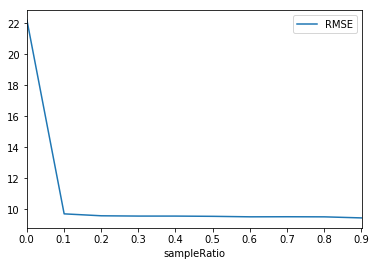

In [5]:
df = pd.DataFrame(list(stat.items()), columns=['sampleRatio','RMSE']).sort_values(by=['sampleRatio'])
print(df)
df.plot.line(x='sampleRatio', y='RMSE')

In [6]:
%autoreload

wt_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sp_fileList = {'../data/PLdata_nonsan_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sm_fileList = {'../data/PLdata_nonsan_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(before):(114341, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(10209, 4)
         type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 416    m      1.01    111.36      0.02       0        400        30       15        2
     417    m      1.01    118.40      0.02       0        400        30       15        2
     418    m      1.01    112.88      0.02       0        400        30       15        2
     419    m      1.02    110.68      0.02       0        400        30       15        2
     420    m      1.03    109.04      0.02       0        400        30       15     

In [7]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'
scale = "manual"
stat = {}

sampleRange = np.arange(0.001, 1.0, 0.1)
for sampleRatio in sampleRange:
    rmse_sum = 0

    addDataSampled = samplingData(addData[targetCols], sampleRatio, None, prFlag = False)
    # addDataSample.sort_values(by=['logDistance'])
    print("sample size:",addDataSampled['pathloss'].count())
    addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale, prFlag = False)

    X = np.array(addDataNorm[xCols])
    Xorigin = np.array(addData[xCols]) 
    Y = np.array(addDataSampled[yCols])

    kf = KFold(n_splits=5, shuffle=True)
    bestTestError = 0
    bestModel = None
    i = 1

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]    
        model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
        model.fit(X_train, y_train.flatten())

        pred_test = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        mae = mean_absolute_error(y_test, pred_test)
        mape = mean_absolute_percentage_error(y_test, pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        r2 = r2_score(y_test, pred_test)
#         print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))     

        rmse_sum += rmse

        i+=1
    avgRMSE = rmse_sum / 5
    print("sampleRatio:",sampleRatio)
#     print("Worst Model:",worstModel)
    print("Average Test Error(RMSE):",avgRMSE)
    stat[sampleRatio] = avgRMSE

sample size: 46
sampleRatio: 0.001
Average Test Error(RMSE): 15.474354610922267
sample size: 4675


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


sampleRatio: 0.101
Average Test Error(RMSE): 7.609020910315991
sample size: 9304
sampleRatio: 0.201
Average Test Error(RMSE): 7.499773667749733
sample size: 13933
sampleRatio: 0.30100000000000005
Average Test Error(RMSE): 7.501138684987206
sample size: 18562
sampleRatio: 0.401
Average Test Error(RMSE): 7.430263654269597
sample size: 23191
sampleRatio: 0.501
Average Test Error(RMSE): 7.363490210566201
sample size: 27820
sampleRatio: 0.6010000000000001
Average Test Error(RMSE): 7.44010803657315
sample size: 32449
sampleRatio: 0.7010000000000001
Average Test Error(RMSE): 7.39022099268568
sample size: 37077
sampleRatio: 0.801
Average Test Error(RMSE): 7.484259960677802
sample size: 41706
sampleRatio: 0.901
Average Test Error(RMSE): 7.3888722745757125


   sampleRatio  RMSE
3         0.00 15.47
0         0.10  7.61
1         0.20  7.50
8         0.30  7.50
4         0.40  7.43
7         0.50  7.36
6         0.60  7.44
5         0.70  7.39
2         0.80  7.48
9         0.90  7.39


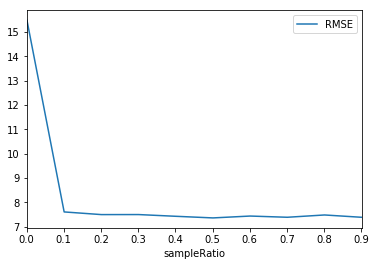

In [8]:
df = pd.DataFrame(list(stat.items()), columns=['sampleRatio','RMSE']).sort_values(by=['sampleRatio'])
print(df)
df.plot.line(x='sampleRatio', y='RMSE')

In [12]:
%autoreload

wt_fileList = {'../data/PLdata_iksan_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sp_fileList = {'../data/PLdata_iksan_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sm_fileList = {'../data/PLdata_iksan_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 2713    m      1.00     97.57      0.01       0       2249        30       15        2
     2714    m      1.00    137.38      0.03       0       2249        30       15        2
     2715    m      1.00     99.98      0.01       0       2249        30       15        2
     2716    m      1.00    128.57      0.04       0       2249        30       15        2
     2717    m      1.00    119.13      0.03       0       2249        30       15     

In [13]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'
scale = "manual"
stat = {}

sampleRange = np.arange(0.001, 1.0, 0.1)
for sampleRatio in sampleRange:
    rmse_sum = 0

    addDataSampled = samplingData(addData[targetCols], sampleRatio, None, prFlag = False)
    # addDataSample.sort_values(by=['logDistance'])
    print("sample size:",addDataSampled['pathloss'].count())
    addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale, prFlag = False)

    X = np.array(addDataNorm[xCols])
    Xorigin = np.array(addData[xCols]) 
    Y = np.array(addDataSampled[yCols])

    kf = KFold(n_splits=5, shuffle=True)
    bestTestError = 0
    bestModel = None
    i = 1

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]    
        model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
        model.fit(X_train, y_train.flatten())

        pred_test = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        mae = mean_absolute_error(y_test, pred_test)
        mape = mean_absolute_percentage_error(y_test, pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        r2 = r2_score(y_test, pred_test)
#         print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))     

        rmse_sum += rmse

        i+=1
    avgRMSE = rmse_sum / 5
    print("sampleRatio:",sampleRatio)
#     print("Worst Model:",worstModel)
    print("Average Test Error(RMSE):",avgRMSE)
    stat[sampleRatio] = avgRMSE

sample size: 65
sampleRatio: 0.001
Average Test Error(RMSE): 27.69225839571316
sample size: 6601


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


sampleRatio: 0.101
Average Test Error(RMSE): 14.312274946607792
sample size: 13136
sampleRatio: 0.201
Average Test Error(RMSE): 13.979021061761955
sample size: 19672
sampleRatio: 0.30100000000000005
Average Test Error(RMSE): 13.99456111415752
sample size: 26207
sampleRatio: 0.401
Average Test Error(RMSE): 13.934953157613256
sample size: 32742
sampleRatio: 0.501
Average Test Error(RMSE): 13.9409320763307
sample size: 39278
sampleRatio: 0.6010000000000001
Average Test Error(RMSE): 13.997120975288354
sample size: 45813
sampleRatio: 0.7010000000000001
Average Test Error(RMSE): 14.017102681936356
sample size: 52349
sampleRatio: 0.801
Average Test Error(RMSE): 13.958796929900174
sample size: 58884
sampleRatio: 0.901
Average Test Error(RMSE): 13.763468336777498


   sampleRatio  RMSE
3         0.00 27.69
0         0.10 14.31
1         0.20 13.98
8         0.30 13.99
4         0.40 13.93
7         0.50 13.94
6         0.60 14.00
5         0.70 14.02
2         0.80 13.96
9         0.90 13.76


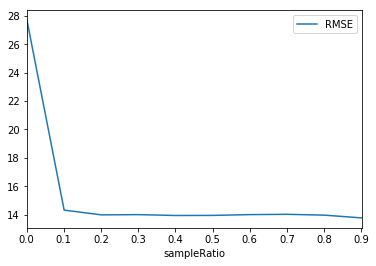

In [14]:
df = pd.DataFrame(list(stat.items()), columns=['sampleRatio','RMSE']).sort_values(by=['sampleRatio'])
print(df)
df.plot.line(x='sampleRatio', y='RMSE')